#MLP

Research Paper: https://www.jmlr.org/papers/volume3/bengio03a/bengio03a.pdf

In [42]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In [43]:
# download the names.txt file from github
!wget https://raw.githubusercontent.com/karpathy/makemore/master/names.txt

--2024-07-19 11:57:47--  https://raw.githubusercontent.com/karpathy/makemore/master/names.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 228145 (223K) [text/plain]
Saving to: ‘names.txt.1’

names.txt.1         100%[===================>] 222.80K  --.-KB/s    in 0.04s   

2024-07-19 11:57:47 (6.12 MB/s) - ‘names.txt.1’ saved [228145/228145]



In [44]:
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [45]:
len(words)

32033

In [46]:
set(''.join(words))

{'a',
 'b',
 'c',
 'd',
 'e',
 'f',
 'g',
 'h',
 'i',
 'j',
 'k',
 'l',
 'm',
 'n',
 'o',
 'p',
 'q',
 'r',
 's',
 't',
 'u',
 'v',
 'w',
 'x',
 'y',
 'z'}

In [47]:
# build the vocabulary of characters and mappings to/from integers
chars=sorted(list(set(''.join(words))))
stoi={s:i+1 for i,s in enumerate(chars)}
stoi['.']=0
itos={i:s for s,i in stoi.items()}
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [48]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?
X, Y = [], []
for w in words[:5]:

  print(w)
  context = [0] * block_size
  for ch in w + '.':
    ix = stoi[ch]
    X.append(context)
    Y.append(ix)
    print(''.join(itos[i] for i in context), '--->', itos[ix])
    context = context[1:] + [ix] # crop and append

X = torch.tensor(X)
Y = torch.tensor(Y)
print(X.shape, Y.shape)


emma
... ---> e
..e ---> m
.em ---> m
emm ---> a
mma ---> .
olivia
... ---> o
..o ---> l
.ol ---> i
oli ---> v
liv ---> i
ivi ---> a
via ---> .
ava
... ---> a
..a ---> v
.av ---> a
ava ---> .
isabella
... ---> i
..i ---> s
.is ---> a
isa ---> b
sab ---> e
abe ---> l
bel ---> l
ell ---> a
lla ---> .
sophia
... ---> s
..s ---> o
.so ---> p
sop ---> h
oph ---> i
phi ---> a
hia ---> .
torch.Size([32, 3]) torch.Size([32])


In [49]:
C=torch.randn((27,2))

In [50]:
C[5]

tensor([-1.5157, -0.9143])

In [51]:
F.one_hot(torch.tensor(5),num_classes=27).float() @ C

tensor([-1.5157, -0.9143])

In [52]:
emb=C[X]
emb.shape

torch.Size([32, 3, 2])

In [53]:
W1=torch.randn((6,100))
b1=torch.randn(100)

In [54]:
#emb @ W1 + b1
#RuntimeError: mat1 and mat2 shapes cannot be multiplied (96x2 and 6x100)

In [55]:
torch.cat((emb[:,0,:],emb[:,1,:],emb[:,2,:]),1).shape

torch.Size([32, 6])

In [56]:
#torch.unbind
#Removes a tensor dimension.

#Returns a tuple of all slices along a given dimension, already without it.
##torch.unbind(emb,1)

torch.unbind(torch.tensor([[1, 2, 3],
                            [4, 5, 6],
                            [7, 8, 9]]))

(tensor([1, 2, 3]), tensor([4, 5, 6]), tensor([7, 8, 9]))

In [57]:
torch.cat(torch.unbind(emb,1),1).shape

torch.Size([32, 6])

In [58]:
a=torch.arange(18)
a,a.shape

(tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17]),
 torch.Size([18]))

In [59]:
a.view(2,9)

tensor([[ 0,  1,  2,  3,  4,  5,  6,  7,  8],
        [ 9, 10, 11, 12, 13, 14, 15, 16, 17]])

In [60]:
a.view(2,3,3)

tensor([[[ 0,  1,  2],
         [ 3,  4,  5],
         [ 6,  7,  8]],

        [[ 9, 10, 11],
         [12, 13, 14],
         [15, 16, 17]]])

In [61]:
a.storage() #storage is how tensors are stored; 1 dim tensor

 0
 1
 2
 3
 4
 5
 6
 7
 8
 9
 10
 11
 12
 13
 14
 15
 16
 17
[torch.storage.TypedStorage(dtype=torch.int64, device=cpu) of size 18]

In [62]:
emb.shape

torch.Size([32, 3, 2])

In [63]:
emb.view(32,6).shape

torch.Size([32, 6])

In [64]:
emb.view(32,6)==torch.cat((emb[:,0,:],emb[:,1,:],emb[:,2,:]),1)

tensor([[True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, T

In [65]:
#emb @ W1 + b1
#RuntimeError: mat1 and mat2 shapes cannot be multiplied (96x2 and 6x100)
#-1 is used for pytorch to derive shape from
emb.view(-1,6) @ W1 + b1

tensor([[-6.4065, -0.4336,  0.2393,  ..., -1.5765, -3.0830,  3.2890],
        [-5.6748, -4.1539,  0.3308,  ...,  2.7928, -7.0660,  0.9646],
        [-5.5911, -1.1940, -2.9491,  ..., -2.3122, -5.8488, -2.4948],
        ...,
        [-2.5320,  0.4118,  0.7067,  ..., -4.4176, -1.2887,  4.1448],
        [-5.0554,  5.5639, -0.0460,  ..., -4.0423,  2.9769,  2.6734],
        [-6.5563,  5.6700,  0.4275,  ...,  2.4395,  3.7824,  1.8372]])

In [66]:
h=torch.tanh(emb.view(-1,6) @ W1 + b1)
h,h.shape

(tensor([[-1.0000, -0.4084,  0.2348,  ..., -0.9181, -0.9958,  0.9972],
         [-1.0000, -0.9995,  0.3193,  ...,  0.9925, -1.0000,  0.7463],
         [-1.0000, -0.8318, -0.9945,  ..., -0.9806, -1.0000, -0.9865],
         ...,
         [-0.9874,  0.3900,  0.6086,  ..., -0.9997, -0.8588,  0.9995],
         [-0.9999,  1.0000, -0.0460,  ..., -0.9994,  0.9948,  0.9905],
         [-1.0000,  1.0000,  0.4032,  ...,  0.9849,  0.9990,  0.9505]]),
 torch.Size([32, 100]))

In [67]:
h.shape, b1.shape #in order to do mult/add need to/will convert from [100] to 1,100 tensor

(torch.Size([32, 100]), torch.Size([100]))

In [68]:
W2=torch.randn((100,27))
b2=torch.randn(27)

In [69]:
logits=h @ W2 + b2
logits.shape

torch.Size([32, 27])

In [73]:
logits[5]

tensor([-1.9552, -8.7643, -1.5541, -8.4538, -0.6163, -0.3488,  3.2923, -1.6210,
        -5.0856, 10.4311, -0.9736, -4.2835, -6.5413, -4.9808, 11.1395,  5.2397,
         1.2010,  8.9121, -8.9195, 17.2472,  8.4364, -2.1096,  4.6357, -4.2097,
        -1.1565,  4.1796,  7.2928])

In [70]:
counts=logits.exp()
counts.shape

torch.Size([32, 27])

In [74]:
counts[5]

tensor([1.4154e-01, 1.5620e-04, 2.1138e-01, 2.1309e-04, 5.3996e-01, 7.0554e-01,
        2.6904e+01, 1.9770e-01, 6.1850e-03, 3.3898e+04, 3.7773e-01, 1.3794e-02,
        1.4425e-03, 6.8685e-03, 6.8838e+04, 1.8862e+02, 3.3235e+00, 7.4215e+03,
        1.3376e-04, 3.0929e+07, 4.6117e+03, 1.2129e-01, 1.0310e+02, 1.4851e-02,
        3.1459e-01, 6.5340e+01, 1.4697e+03])

In [71]:
prob=counts/counts.sum(1,keepdim=True)
prob.shape

torch.Size([32, 27])

In [77]:
prob[torch.arange(32),Y]

tensor([2.2726e-08, 2.1512e-07, 3.1143e-05, 7.1975e-08, 6.3404e-04, 6.0754e-06,
        6.2537e-16, 1.4229e-10, 2.3084e-05, 2.3407e-09, 9.9993e-01, 1.1059e-06,
        5.0314e-12, 4.2228e-04, 4.1716e-03, 9.3177e-09, 1.0919e-03, 9.9631e-01,
        5.2355e-04, 3.1444e-06, 4.4541e-12, 9.3513e-03, 1.4062e-06, 3.8963e-08,
        1.1626e-12, 9.9624e-01, 2.0073e-10, 1.4202e-09, 9.3753e-12, 1.4039e-01,
        1.8425e-05, 1.3719e-11])

In [76]:
Y

tensor([ 5, 13, 13,  1,  0, 15, 12,  9, 22,  9,  1,  0,  1, 22,  1,  0,  9, 19,
         1,  2,  5, 12, 12,  1,  0, 19, 15, 16,  8,  9,  1,  0])

In [78]:
loss=-prob[torch.arange(32),Y].log().mean()
loss

tensor(14.3969)

###More respectable

In [79]:
X.shape, Y.shape

(torch.Size([32, 3]), torch.Size([32]))

In [81]:
g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((27, 10), generator=g)
W1 = torch.randn((30, 200), generator=g)
b1 = torch.randn(200, generator=g)
W2 = torch.randn((200, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

In [82]:
sum(p.nelement() for p in parameters) # number of parameters in total

11897

In [83]:
emb=C[X]
h=torch.tanh(emb.view(-1,30) @ W1 + b1) #(32,100)
logits=h @ W2 + b2 #(32,27)
counts=logits.exp()
probs=counts/counts.sum(1,keepdim=True)
loss=-probs[torch.arange(32),Y].log().mean()
loss
#loss=F.cross_entropy(logits,Y)

tensor(29.6480)

In [84]:
loss=F.cross_entropy(logits,Y)
loss

tensor(29.6480)

In [85]:
logits=torch.tensor([-100,-3,0,100])
counts=logits.exp()
probs=counts/counts.sum()
probs

tensor([0., 0., 0., nan])

In [86]:
logits=torch.tensor([-5,-3,0,5])
counts=logits.exp()
probs=counts/counts.sum()
probs

tensor([4.5079e-05, 3.3309e-04, 6.6903e-03, 9.9293e-01])

In [89]:
#cross_entropy is better than manually as stated by above 2 cells
#forward pass
# forward pass

for p in parameters:
  p.requires_grad=True
for _ in range(7):
  emb = C[X] # (32, 3, 2)
  h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100)
  logits = h @ W2 + b2 # (32, 27)
  loss = F.cross_entropy(logits, Y)
  print(loss.item())

  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()
  #update
  for p in parameters:
    #p.grad = None
    p.data+=-0.1 * p.grad
  #loss.backward()

21.828020095825195
15.413897514343262
11.780111312866211
9.044669151306152
7.382572174072266
5.4028472900390625
4.311253070831299


###full Data set

In [90]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?
X, Y = [], []
for w in words:

  #print(w)
  context = [0] * block_size
  for ch in w + '.':
    ix = stoi[ch]
    X.append(context)
    Y.append(ix)
    #print(''.join(itos[i] for i in context), '--->', itos[ix])
    context = context[1:] + [ix] # crop and append

X = torch.tensor(X)
Y = torch.tensor(Y)
print(X.shape, Y.shape)

torch.Size([228146, 3]) torch.Size([228146])


In [91]:
for p in parameters:
  p.requires_grad=True
for _ in range(7):
  emb = C[X] # (32, 3, 2)
  h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100)
  logits = h @ W2 + b2 # (32, 27)
  loss = F.cross_entropy(logits, Y)
  print(loss.item())

  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()
  #update
  for p in parameters:
    #p.grad = None
    p.data+=-0.1 * p.grad
  #loss.backward()

20.699485778808594
19.80644416809082
19.15300750732422
18.607206344604492
18.073673248291016
17.54008674621582
17.11963653564453


In [93]:
torch.randint(0,X.shape[0],(32,))

tensor([ 91308,   1808,  16565,  51143, 117174, 199183,   4873, 106064, 109402,
         58283, 204894, 224495, 203274,  86651, 118777,   4818, 185900,  34460,
        204138,  32469, 123737, 225134,  51855, 105644,  93120,  66161, 137897,
        172945,  99932,  28003, 104630,  30347])

In [95]:
for p in parameters:
  p.requires_grad=True
for _ in range(777):

  #minibatch contruct
  ix=torch.randint(0,X.shape[0],(32,))

  emb = C[X[ix]] # (32, 3, 2)
  h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100)
  logits = h @ W2 + b2 # (32, 27)
  loss = F.cross_entropy(logits, Y[ix])
  #print(loss.item())

  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()
  #update
  for p in parameters:
    #p.grad = None
    p.data+=-0.1 * p.grad
  #loss.backward()

print(loss.item())

3.7201766967773438


###reset parameters

In [96]:
g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((27, 10), generator=g)
W1 = torch.randn((30, 200), generator=g)
b1 = torch.randn(200, generator=g)
W2 = torch.randn((200, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

In [97]:
sum(p.nelement() for p in parameters) # number of parameters in total

11897

In [100]:
for p in parameters:
  p.requires_grad=True
for _ in range(10):

  #minibatch contruct
  ix=torch.randint(0,X.shape[0],(32,))

  emb = C[X[ix]] # (32, 3, 2)
  h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100)
  logits = h @ W2 + b2 # (32, 27)
  loss = F.cross_entropy(logits, Y[ix])
  print(loss.item())

  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()
  #update
  for p in parameters:
    #p.grad = None
    p.data+=-0.01 * p.grad #hyperparameter
  #loss.backward()

#print(loss.item())

26.009403228759766
21.998525619506836
18.684778213500977
23.56251335144043
24.755813598632812
20.994525909423828
23.387117385864258
18.60764503479004
19.684133529663086
16.846654891967773


In [102]:
#torch.linspace(0,1,1000) #1000 numbers between 0,1
lre=torch.linspace(-3,0,1000)
lrs=10**lre
lrs

tensor([0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0011,
        0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011,
        0.0011, 0.0011, 0.0011, 0.0012, 0.0012, 0.0012, 0.0012, 0.0012, 0.0012,
        0.0012, 0.0012, 0.0012, 0.0012, 0.0012, 0.0012, 0.0013, 0.0013, 0.0013,
        0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0014,
        0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014,
        0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015,
        0.0015, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016,
        0.0016, 0.0017, 0.0017, 0.0017, 0.0017, 0.0017, 0.0017, 0.0017, 0.0017,
        0.0018, 0.0018, 0.0018, 0.0018, 0.0018, 0.0018, 0.0018, 0.0018, 0.0019,
        0.0019, 0.0019, 0.0019, 0.0019, 0.0019, 0.0019, 0.0019, 0.0020, 0.0020,
        0.0020, 0.0020, 0.0020, 0.0020, 0.0020, 0.0021, 0.0021, 0.0021, 0.0021,
        0.0021, 0.0021, 0.0021, 0.0022, 

In [107]:
from typing_extensions import LiteralString
g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((27, 10), generator=g)
W1 = torch.randn((30, 200), generator=g)
b1 = torch.randn(200, generator=g)
W2 = torch.randn((200, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

sum(p.nelement() for p in parameters) # number of parameters in total

lri=[]
lossi=[]

for p in parameters:
  p.requires_grad=True
for i in range(1000):

  #minibatch contruct
  ix=torch.randint(0,X.shape[0],(32,))

  emb = C[X[ix]] # (32, 3, 2)
  h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100)
  logits = h @ W2 + b2 # (32, 27)
  loss = F.cross_entropy(logits, Y[ix])
  #print(loss.item())

  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()
  #update
  # for p in parameters:
  #   #p.grad = None
  #   p.data+=-0.01 * p.grad #hyperparameter
  #loss.backward()
  lr=lrs[i]
  for p in parameters:
    p.data+=-lr * p.grad

  #track stats
  lri.append(lr)
  lossi.append(loss.item())

#print(loss.item())

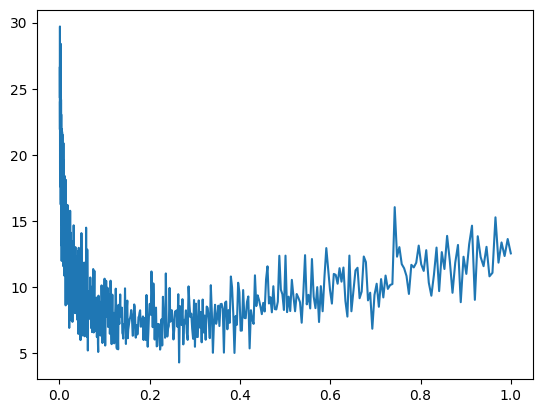

In [108]:
plt.plot(lri,lossi)
#can see from graph that a good learning rate is 0.1

In [109]:

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((27, 10), generator=g)
W1 = torch.randn((30, 200), generator=g)
b1 = torch.randn(200, generator=g)
W2 = torch.randn((200, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

sum(p.nelement() for p in parameters) # number of parameters in total

lri=[]
lossi=[]

for p in parameters:
  p.requires_grad=True
for i in range(10000):

  #minibatch contruct
  ix=torch.randint(0,X.shape[0],(32,))

  emb = C[X[ix]] # (32, 3, 2)
  h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100)
  logits = h @ W2 + b2 # (32, 27)
  loss = F.cross_entropy(logits, Y[ix])
  #print(loss.item())

  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()
  #update
  # for p in parameters:
  #   #p.grad = None
  #   p.data+=-0.01 * p.grad #hyperparameter
  #loss.backward()
  lr=0.1
  for p in parameters:
    p.data+=-lr * p.grad

  # #track stats
  # lri.append(lr)
  # lossi.append(loss.item())

In [110]:
emb=C[X]
h=torch.tanh(emb.view(-1,30) @ W1 + b1) #(32,100)
logits=h @ W2 + b2 #(32,27)
counts=logits.exp()
loss=F.cross_entropy(logits,Y)
loss
#

tensor(2.5440, grad_fn=<NllLossBackward0>)

#####**learning rate decay**: once a good learning rate has been established, once you get to a good point sometimes it would be good to decrease learning rate by 10 factor just for better loss

###training split, dev/validation spolot, text split 80,10,10

In [111]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):
  X, Y = [], []
  for w in words:

    #print(w)
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      #print(''.join(itos[i] for i in context), '--->', itos[ix])
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words)) #80%
n2 = int(0.9*len(words)) #90%

Xtr, Ytr = build_dataset(words[:n1]) #training set
Xdev, Ydev = build_dataset(words[n1:n2]) #validation set
Xte, Yte = build_dataset(words[n2:]) #test set

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [112]:
Xtr.shape, Ytr.shape

(torch.Size([182625, 3]), torch.Size([182625]))

In [114]:
g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((27, 10), generator=g) #10 dim
W1 = torch.randn((30, 200), generator=g) #20 neurons
b1 = torch.randn(200, generator=g)
W2 = torch.randn((200, 27), generator=g) #200 neurons
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

In [115]:
sum(p.nelement() for p in parameters) # number of parameters in total

11897

In [116]:
for p in parameters:
  p.requires_grad = True

In [117]:
lre = torch.linspace(-3, 0, 1000)
lrs = 10**lre
lri = []
lossi = []
stepi = []

In [118]:
for i in range(200000):

  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (32,))

  # forward pass
  emb = C[Xtr[ix]] # (32, 3, 2)
  h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100)
  logits = h @ W2 + b2 # (32, 27)
  loss = F.cross_entropy(logits, Ytr[ix])
  #print(loss.item())

  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()

  # update
  #lr = lrs[i]
  lr = 0.1 if i < 100000 else 0.01
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  #lri.append(lre[i])
  stepi.append(i)
  lossi.append(loss.log10().item())

#print(loss.item())

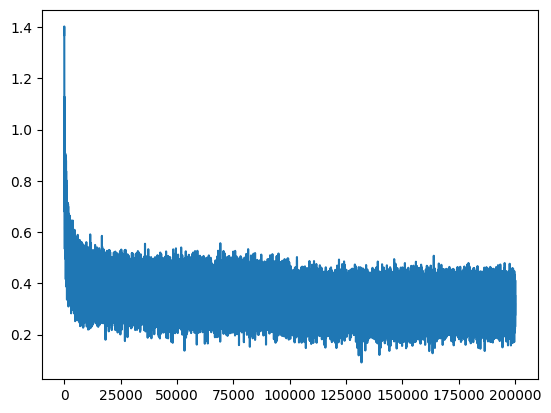

In [121]:
plt.plot(stepi, lossi)

In [119]:
# training loss
emb = C[Xtr] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ytr)
loss

tensor(2.1208, grad_fn=<NllLossBackward0>)

In [120]:
# validation loss
emb = C[Xdev] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ydev)
loss

tensor(2.1581, grad_fn=<NllLossBackward0>)

In [122]:
# test loss
emb = C[Xte] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Yte)
loss

tensor(2.1587, grad_fn=<NllLossBackward0>)

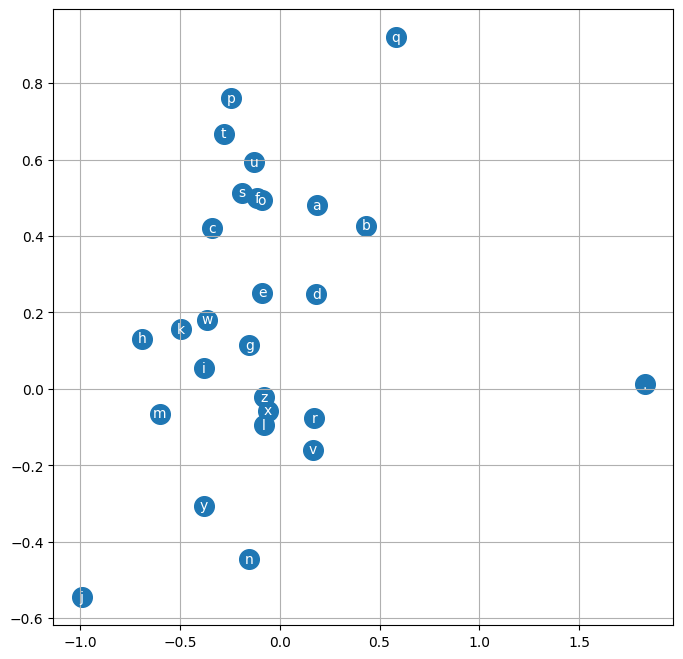

In [123]:
# visualize dimensions 0 and 1 of the embedding matrix C for all characters
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha="center", va="center", color='white')
plt.grid('minor')

In [124]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(7):

    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      emb = C[torch.tensor([context])] # (1,block_size,d)
      h = torch.tanh(emb.view(1, -1) @ W1 + b1)
      logits = h @ W2 + b2
      probs = F.softmax(logits, dim=1)
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      context = context[1:] + [ix]
      out.append(ix)
      if ix == 0:
        break

    print(''.join(itos[i] for i in out))

mora.
mayah.
seel.
ndyn.
alayelyr.
jendra.
graileed.
